In [1]:
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import _pickle as cPickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
import pickle
import re
from sklearn.model_selection import GridSearchCV

In [17]:
df = pd.read_csv('data.csv')

In [18]:
df = df.drop(df[df['Polarity'] == '?'].index)
df = df.dropna(subset=['Polarity'])

In [19]:
df.groupby('Polarity').describe()

Unnamed: 0                                                       \
              count        mean         std  min     25%    50%      75%   
Polarity                                                                   
-1.0          349.0  659.280802  383.161113  5.0  287.00  634.0  1012.00   
 0.0          402.0  769.718905  368.736169  8.0  440.25  805.0  1084.75   
 1.0          605.0  632.876033  404.390056  0.0  291.00  596.0   964.00   

                  
             max  
Polarity          
-1.0      1307.0  
 0.0      1359.0  
 1.0      1358.0

In [20]:
X = df['Tweet_Content']
y = df['Polarity']

In [21]:
with open('Emoji_Dict.p', 'rb') as emoji_file:
    emoji_dict = pickle.load(emoji_file)

In [22]:
def map_emoji_to_emotion(tweet):
    # Assuming `tweet` is a string containing the tweet text
    # Iterate through each character in the tweet
    for char in tweet:
        # Check if the character is an emoji and exists in the emoji_dict
        if char in emoji_dict:
            # Map the emoji to its corresponding emotion
            emotion = emoji_dict[char]
            print(f"Emoji: {char}, Emotion: {emotion}")

In [23]:
X.apply(map_emoji_to_emotion)

0       None
1       None
2       None
3       None
4       None
        ... 
1355    None
1356    None
1357    None
1358    None
1359    None
Name: Tweet_Content, Length: 1356, dtype: object

In [24]:
def split_into_lemmas(content):
    # Remove '@' and '#' symbols
    content = re.sub(r'[@#]', '', content)
    # Convert to lowercase
    content = content.lower()
    # Tokenize and lemmatize
    words = TextBlob(content).words
    return ' '.join([word.lemma for word in words])

X.apply(split_into_lemmas)

0       big breaking youth of bahrain just burnt israe...
1       egyptian comedian bassem youssef on israel “ i...
2       breaking israel destroyed the largest tower in...
3       breaking a super massive demonstration in paki...
4       umm i think the needed some help to correct th...
                              ...                        
1355    martyr of aqsa from hezbollahpalestine gaza he...
1356    israel arrested a woman who is unable to walks...
1357    a entire world now busy with israel and palest...
1358    a story told in tearsthat 's every individual ...
1359    maya a 6 year old palestinian girl ha to carry...
Name: Tweet_Content, Length: 1356, dtype: object

In [25]:
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

# Create a TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

In [26]:
tfidf_transformer = TfidfTransformer()

content_tfidf = tfidf_transformer.fit_transform(X_tfidf)
print (content_tfidf.shape)

(1356, 6639)


In [13]:
# spam_detector = MultinomialNB().fit(content_tfidf, df['Polarity'])

# #How many messages does it classify correctly overall?
# all_predictions = spam_detector.predict(content_tfidf)
# print (all_predictions)

In [14]:
# print ('accuracy', accuracy_score(df['Polarity'], all_predictions))
# print ('confusion matrix\n', confusion_matrix(df['Polarity'], all_predictions))
# print ('(row=expected, col=predicted)')

In [15]:
# plt.matshow(confusion_matrix(df['Polarity'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
# plt.title('confusion matrix')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(content_tfidf, y, test_size=0.2, random_state=42)

In [16]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [17]:
%time svm_detector = grid_svm.fit(X_train, y_train) # find the best combination from param_svm
print('Confusion Matrix : \n')
print(confusion_matrix(y_test, svm_detector.predict(X_test)))
print(classification_report(y_test, svm_detector.predict(X_test)))

CPU times: total: 1.09 s
Wall time: 1min 36s
Confusion Matrix : 

[[26 12 25]
 [20 18 44]
 [17 12 98]]
              precision    recall  f1-score   support

        -1.0       0.41      0.41      0.41        63
         0.0       0.43      0.22      0.29        82
         1.0       0.59      0.77      0.67       127

    accuracy                           0.52       272
   macro avg       0.48      0.47      0.46       272
weighted avg       0.50      0.52      0.49       272



In [18]:
print (svm_detector.predict(["Pro Israel clowns are actually trying to compare gal galot to the Palestinian Queen Bella Hadid. Be real for once."])[0])
print (svm_detector.predict(["Funny that... show me one pro Israel protest that turned into such brutal and blatant violation of law and order. #TheWestIsNextisHere #HamasIsISIS #IStandWithIsrael"])[0])

1.0
-1.0


In [31]:
train_accuracy_list = []
test_accuracy_list = []

for i in range(200, len(X_train), 100):
    partial_X_train = X_train[:i]
    partial_y_train = y_train[:i]
    svm_detector.fit(partial_X_train, partial_y_train)

    train_predictions = svm_detector.predict(partial_X_train)
    test_predictions = svm_detector.predict(X_test)
    train_accuracy = accuracy_score(partial_y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    print("done with", i)

done with 200
done with 300
done with 400
done with 500
done with 600
done with 700
done with 800
done with 900
done with 1000


In [33]:
print(train_accuracy_list)
print(test_accuracy_list)

[0.46, 0.47, 0.61, 0.584, 0.5933333333333334, 0.5971428571428572, 0.59625, 0.59, 0.575]
[0.46691176470588236, 0.46691176470588236, 0.48161764705882354, 0.5036764705882353, 0.5183823529411765, 0.5294117647058824, 0.5220588235294118, 0.5330882352941176, 0.5330882352941176]


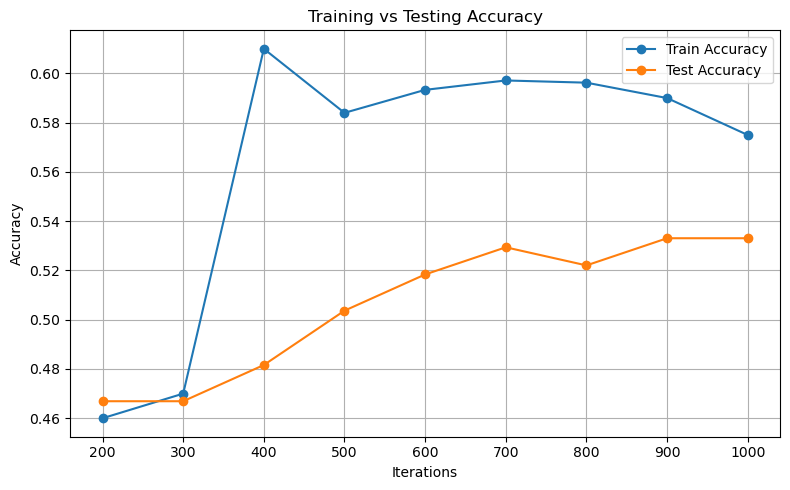

In [35]:
iterations = range(200, len(X_train), 100)

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(iterations, train_accuracy_list, marker='o', linestyle='-', label='Train Accuracy')
plt.plot(iterations, test_accuracy_list, marker='o', linestyle='-', label='Test Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.xticks(iterations)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

## Naive Bayes

In [31]:
naive_bayes = MultinomialNB().fit(X_train, y_train)

# #How many tweets does it classify correctly overall?
train_predictions = naive_bayes.predict(X_train)
print (train_predictions)

[-1.  1. -1. ...  0.  0.  1.]


In [33]:
print ('accuracy', accuracy_score(y_train, train_predictions))
print ('confusion matrix\n', confusion_matrix(y_train, train_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.8837638376383764
confusion matrix
 [[230   1  55]
 [  1 251  68]
 [  1   0 477]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

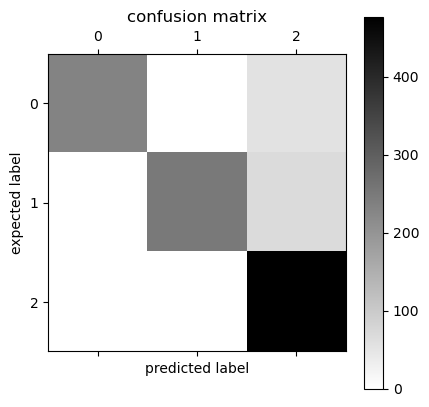

In [35]:
plt.matshow(confusion_matrix(y_train, train_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [37]:
test_predictions = naive_bayes.predict(X_test)

In [38]:
print ('accuracy', accuracy_score(y_test, test_predictions))
print ('confusion matrix\n', confusion_matrix(y_test, test_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.5477941176470589
confusion matrix
 [[ 14   2  47]
 [  5  11  66]
 [  2   1 124]]
(row=expected, col=predicted)
